### Notebook to prepare the full dataset used for training of different models, combining different code throughout this repo


In [76]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
# Defining important metrics and functions

# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2pixarea(NSIDE, degrees=True)))

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


### 1. Get a catalogue of all objects in the Galaxy Survey



In [ ]:
df_north = pd.read_csv('../../bricks_data/galaxy_catalogue_north.csv', dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_north.head()


In [ ]:
df_south = pd.read_csv('../../bricks_data/galaxy_catalogue_south.csv', dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})

df_south.head()


In [ ]:
print(len(df_north.BrickID.unique()))
print(len(df_south.BrickID.unique()))
print(len(df_north.BrickID.unique()) + len(df_south.BrickID.unique()))

In [ ]:
df = pd.concat((df_south,df_north), axis=0)

In [ ]:
print(len(df))

In [ ]:
print(df.shape)
duplicates_removed = df.drop_duplicates()

print(duplicates_removed.shape)

In [ ]:
df = duplicates_removed

print(len(df.BrickID.unique()))

In [ ]:
print(df.isna().sum())

In [ ]:
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_objects = df.dropna(axis=0, inplace=False, how='any')

print(len(df_objects.BrickID.unique()))
print(len(df_objects))

### 2. Get Galaxy Count per Healpy Pixel


In [ ]:
# LRG

df_LRG = df_objects[df_objects["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

In [ ]:
# elg

df_ELG = df_objects[df_objects["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

In [ ]:
df_QSO = df_objects[df_objects["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

In [ ]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

In [ ]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())
print( df.shape)

### 3. Plotting Galaxy Densities

In [ ]:
m_LRG = np.zeros(NPIX)

m_LRG[df.pixel_id.to_numpy()] = df.lrg.to_numpy()
mask = (m_LRG == 0)
m_LRG[mask] = np.nan
hp.mollview(m_LRG, title="LRG", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
m_ELG = np.zeros(NPIX)

m_ELG[df.pixel_id.to_numpy()] = df.elg.to_numpy()
mask = (m_ELG == 0)
m_ELG[mask] = np.nan
hp.mollview(m_ELG, title="ELG", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
m_QSO = np.zeros(NPIX)

m_QSO[df.pixel_id.to_numpy()] = df.qso.to_numpy()
mask = (m_QSO == 0)
m_QSO[mask] = np.nan
hp.mollview(m_QSO, title="QSO", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [ ]:
# Getting Exposure Densities across pixels

with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [ ]:
df = df.astype(int)
df.head()

In [ ]:
df_exp = df
#df_exp['exposures'] = np.zeros(len(df_exp))
df_exp.head()

In [ ]:
pix_ids = df_exp.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df_exp['exposures'] = exp_len

df_exp.head()

In [ ]:
m_EXP = np.zeros(NPIX)

m_EXP[df.pixel_id.to_numpy()] = df.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [70]:
df_stellar_north = pd.read_csv('../../bricks_data/stellar_catalogue_north.csv')


In [71]:
df_stellar_south = pd.read_csv('../../bricks_data/stellar_catalogue_south.csv')

In [72]:
df_stellar_north.head()

,RA,DEC,GMAG,RMAG,ZMAG
0,140.898014,39.467598,18.104998,17.247044,16.888790
1,140.931050,39.523490,18.810522,17.796021,17.333416
2,140.957915,39.428128,19.376871,17.902054,16.362108
3,140.972733,39.467930,19.390877,17.886087,16.718546
4,140.981984,39.563177,18.225065,17.742722,17.618404


In [74]:
print(len(df_stellar_north) + len(df_stellar_south))

12678642


In [75]:
df_stellar = pd.concat((df_stellar_south,df_stellar_north), axis=0)


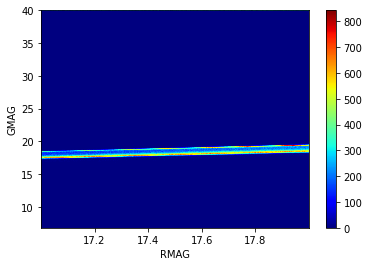

In [77]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [78]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(12678642, 5)


In [79]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [80]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4) ]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4) ]
print(df_stellar.shape)


(12066445, 7)


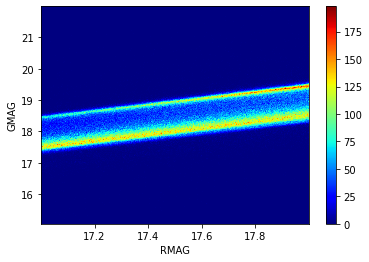

In [81]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [82]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


834    12108
864    12106
957    12105
919    12102
387    12099
       ...  
715    12033
921    12031
865    12027
835    12025
958    12021
Name: percent_RMAG, Length: 1000, dtype: int64

In [83]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [84]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(12066445, 12)

In [85]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [86]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [87]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(12066445, 12)
(11977611, 12)


(11923539, 12)

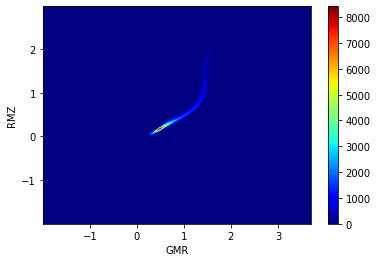

In [88]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [89]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 11923539
[  1560   1561   1562 ... 757955 758426 758427]
Mean stellars per Pixel: 31.78593250159949
[[  1560      1]
 [  1561      3]
 [  1562      2]
 ...
 [757955      4]
 [758426      2]
 [758427      2]]
   pixel_id  stellar
0      1560        1
1      1561        3
2      1562        2
3      1565        3
4      1572        1
pixel_id    0
stellar     0
dtype: int64


In [91]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id     0
lrg          0
elg          0
qso          0
exposures    0
stellar      0
dtype: int64


(373667, 6)

In [92]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar
0,1560,1,7,8,11.0,1
1,1561,3,4,6,10.0,3
2,1562,1,5,6,10.0,2
3,1565,2,11,7,9.0,3
4,1572,1,3,10,6.0,1


0.0 180.0 -180.0 180.0


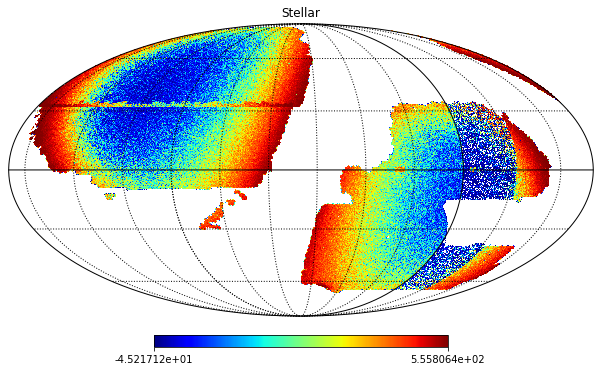

In [94]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df.pixel_id.to_numpy()] = df.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

#### EBV Extraction

In [95]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [98]:
from dustmaps.config import config
config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [99]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE,pixels_ids, lonlat=True)
ra_ebv= subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1560   1561   1562 ... 757954 757955 758427]


In [100]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [101]:
df.EBV.describe()
df.head()


,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11.0,1,0.157148
1,1561,3,4,6,10.0,3,0.277929
2,1562,1,5,6,10.0,2,0.255054
3,1565,2,11,7,9.0,3,0.247232
4,1572,1,3,10,6.0,1,0.209759


0.0 180.0 -180.0 180.0


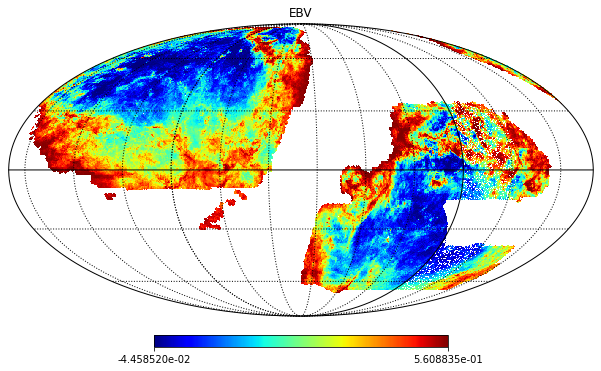

In [102]:
m_EBV = np.zeros(NPIX)

m_EBV[df.pixel_id.to_numpy()] = df.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e' ,norm='hist', cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [104]:
df.exposures = df.exposures.astype(int)
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1565,2,11,7,9,3,0.247232
4,1572,1,3,10,6,1,0.209759


In [105]:
df.to_csv('../../bricks_data/dataset_galdense.csv', index=False)



In [106]:
df = pd.read_csv('../../bricks_data/dataset_galdense.csv', dtype={'pixel_id': 'int32', 'lrg': 'int32', 'elg': 'int32', 'qso': 'int32', 'exposures': 'int32', 'EBV': 'float'})

,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,1560,1,7,8,11,1,0.157148
1,1561,3,4,6,10,3,0.277929
2,1562,1,5,6,10,2,0.255054
3,1565,2,11,7,9,3,0.247232
4,1572,1,3,10,6,1,0.209759
